In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [2]:
import os

# Caminho onde o Kaggle coloca os datasets importados
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"

# Listando os arquivos
print("Arquivos no dataset:", os.listdir(dataset_path))

Arquivos no dataset: ['lung_aca', 'lung_scc', 'lung_n']


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os

# ===============================
# 1. Definições e transformações
# ===============================
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets" 

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamanho padrão da ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalização do ImageNet
                         std=[0.229, 0.224, 0.225])
])

# ===============================
# 2. Carregamento do dataset
# ===============================
dataset = ImageFolder(root=dataset_path, transform=data_transforms)
print("Total de imagens:", len(dataset))
print("Classes encontradas:", dataset.classes)

# ===============================
# 3. Divisão: Treino, Validação e Teste
# ===============================
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Tamanhos -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

# ===============================
# 4. DataLoaders
# ===============================
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Total de imagens: 15000
Classes encontradas: ['lung_aca', 'lung_n', 'lung_scc']
Tamanhos -> Treino: 10500, Validação: 2250, Teste: 2250


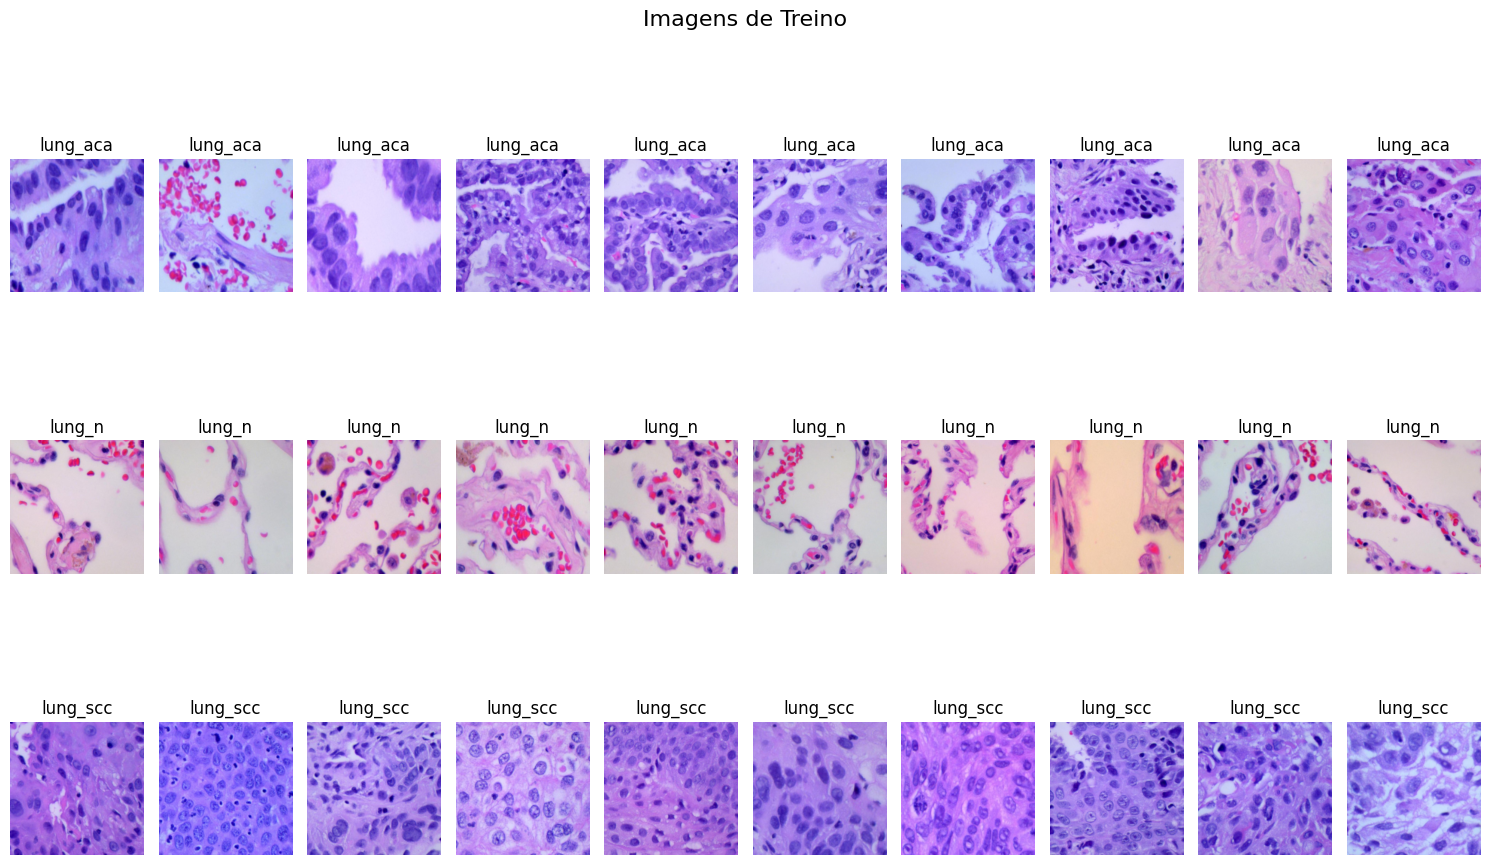

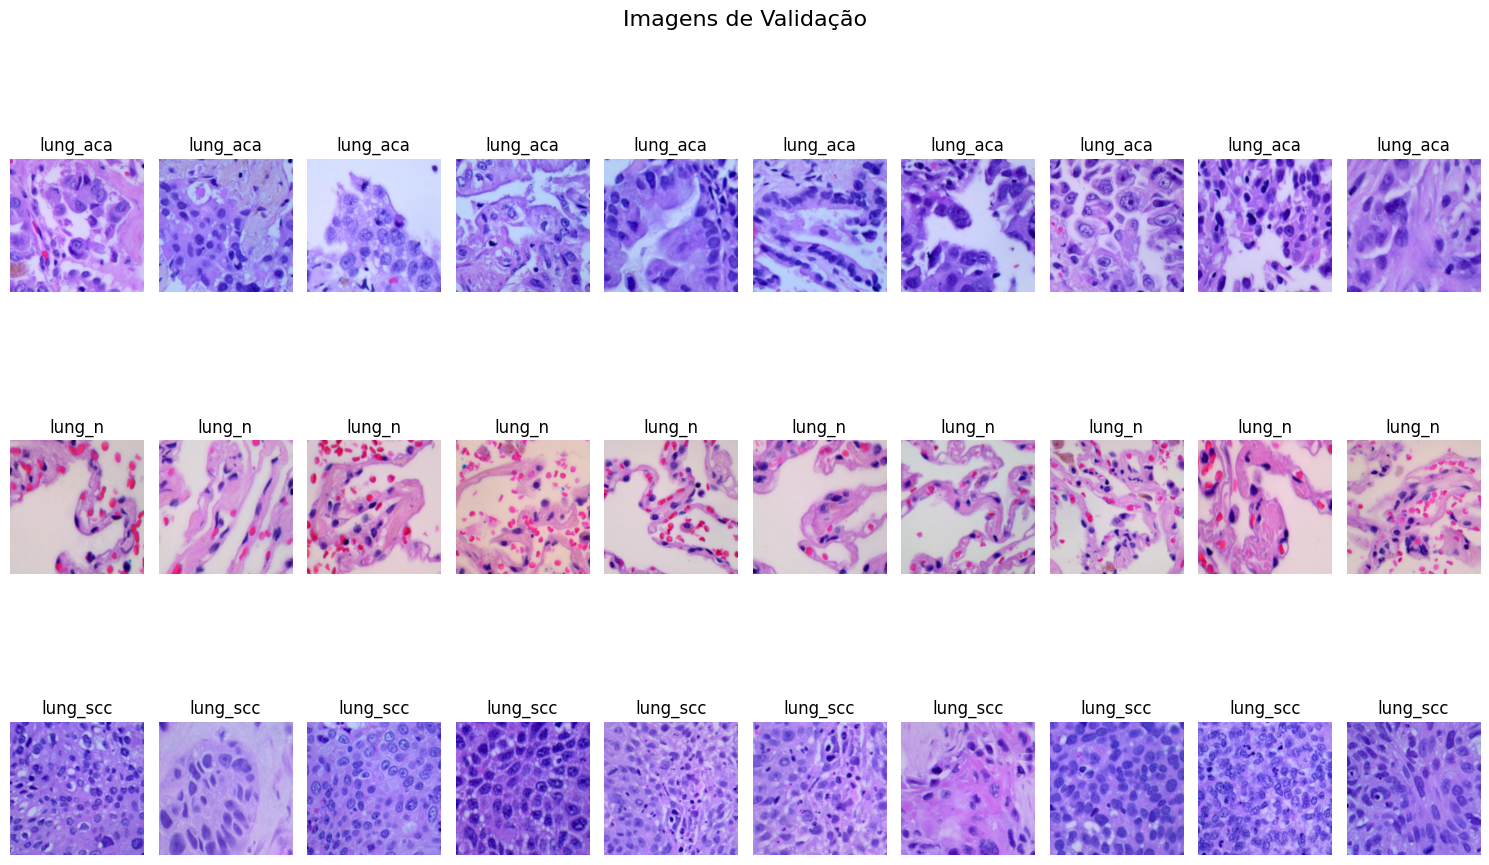

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Função para desnormalizar as imagens (voltar aos valores originais)
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # Médias usadas na normalização
    std = np.array([0.229, 0.224, 0.225])   # Desvios padrão usados na normalização
    img = img.numpy().transpose((1, 2, 0))  # Reorganiza as dimensões do tensor para exibição
    img = img * std + mean  # Reverte a normalização
    img = np.clip(img, 0, 1)  # Garante que os valores fiquem entre 0 e 1
    return img

# Função para exibir imagens do DataLoader
def show_images(dataloader, title, num_images=10):
    class_counts = {class_name: 0 for class_name in dataset.classes}  # Contador de classes
    max_per_class = num_images  # Máximo de imagens por classe

    fig, axes = plt.subplots(len(dataset.classes), num_images, figsize=(15, 10))  # Cria a grade de imagens
    
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_name = dataset.classes[label]  # Nome da classe
            if class_counts[class_name] < max_per_class:
                row = dataset.classes.index(class_name)  # Linha correspondente à classe
                col = class_counts[class_name]  # Próxima coluna disponível
                axes[row, col].imshow(denormalize(img))  # Exibe a imagem desnormalizada
                axes[row, col].axis("off")
                axes[row, col].set_title(class_name)
                class_counts[class_name] += 1
            
            # Para quando todas as classes atingirem 10 imagens
            if all(count >= max_per_class for count in class_counts.values()):
                break
        if all(count >= max_per_class for count in class_counts.values()):
            break

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Exibir imagens do conjunto de treino
show_images(train_loader, "Imagens de Treino", num_images=10)

# Exibir imagens do conjunto de validação
show_images(val_loader, "Imagens de Validação", num_images=10)

In [5]:
import pytorch_lightning as pl
import torch
import torchvision.models as models
import torch.nn as nn

class CancerClassifier(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(CancerClassifier, self).__init__()

        # 🔄 Carrega o modelo VGG19 com pesos pré-treinados
        self.model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

        # 🔁 Substitui a última camada do classificador
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(in_features, num_classes)

        self.criterion = nn.CrossEntropyLoss()

        # 🔹 Criar listas para armazenar as métricas
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        self.train_losses.append(loss.item())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()

        self.val_losses.append(loss.item())
        self.val_accuracies.append(acc.item())

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

# Função para gerar a Matrix confusão

In [6]:
def plot_confusion_matrix_and_metrics(model, dataloader, class_names):
    from sklearn.metrics import (
        confusion_matrix, ConfusionMatrixDisplay,
        accuracy_score, recall_score, precision_score, f1_score, classification_report
    )
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

    # Métricas para múltiplas classes (macro average: trata todas igualmente)
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print("\nMétricas de Desempenho:")
    print(f"Acurácia: {acc:.4f}")
    print(f"Sensibilidade (Recall - média macro): {recall:.4f}")
    print(f"Precisão (Precision - média macro): {precision:.4f}")
    print(f"F1-score (média macro): {f1:.4f}")

    print("\nRelatório de Classificação:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Logger para visualizar métricas no Kaggle
logger = TensorBoardLogger("tb_logs", name="cancer_classifier")

checkpoint_callback = ModelCheckpoint(
    dirpath="meus_modelos/",  
    filename="melhor_modelo",
    monitor="val_acc",
    mode="max",
    save_top_k=5
)


# Inicializando o Trainer do PyTorch Lightning
trainer = Trainer(
    max_epochs=10,
    accelerator="gpu",  # Usa GPU no Kaggle
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback]
)

# Treinando o modelo
model = CancerClassifier(num_classes=3)
trainer.fit(model, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 205MB/s] 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

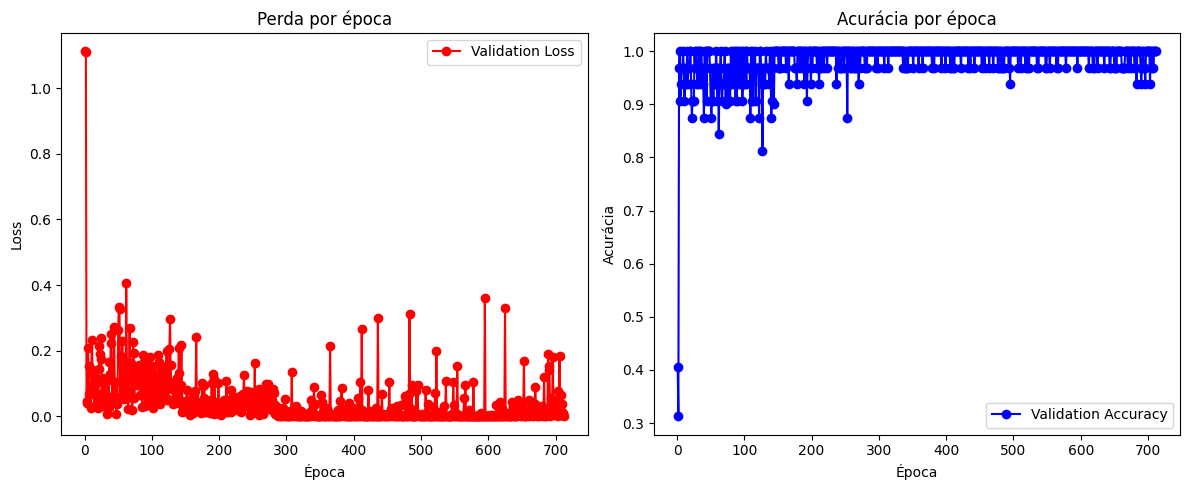

In [8]:
import matplotlib.pyplot as plt

def plot_training_results(model):
    epochs = range(1, len(model.val_losses) + 1)

    # Plotando Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.val_losses, label="Validation Loss", color="red", marker="o")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Perda por época")
    plt.legend()

    # Plotando Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.val_accuracies, label="Validation Accuracy", color="blue", marker="o")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.title("Acurácia por época")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Após o treinamento, chamar essa função:
plot_training_results(model)

In [9]:
import glob

# 🔹 Listar todos os arquivos de checkpoint salvos
checkpoints = glob.glob("meus_modelos/*.ckpt")
print("Modelos salvos:", checkpoints)

Modelos salvos: ['meus_modelos/melhor_modelo-v4.ckpt', 'meus_modelos/melhor_modelo-v3.ckpt', 'meus_modelos/melhor_modelo-v1.ckpt', 'meus_modelos/melhor_modelo-v2.ckpt', 'meus_modelos/melhor_modelo.ckpt']


In [10]:
import torch
import PIL.Image as Image

# Carrega o melhor modelo
best_model_path = checkpoint_callback.best_model_path
model = CancerClassifier.load_from_checkpoint(best_model_path)
model.eval()

# Enviar o modelo para a GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Função para prever imagens com porcentagem de confiança
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Adiciona batch dimension
    
    # Enviar a imagem para a mesma device do modelo
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Aplica softmax para obter probabilidades
        confidence, prediction = torch.max(probabilities, dim=1)  # Obtém a maior probabilidade e índice da classe

    class_name = dataset.classes[prediction.item()]
    confidence_percent = confidence.item() * 100  # Converte para porcentagem

    return class_name, confidence_percent  # Retorna o nome da classe e a confiança

# Testando com uma imagem nova
image_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1023.jpeg"
pred_class, pred_confidence = predict_image(image_path, model, data_transforms)

# Exibe a predição com a confiança
print(f"Predição: {pred_class} ({pred_confidence:.2f}%)")


Predição: lung_aca (100.00%)


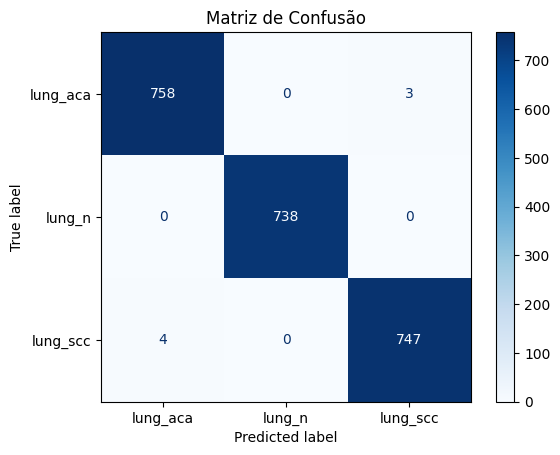


Métricas de Desempenho:
Acurácia: 0.9969
Sensibilidade (Recall - média macro): 0.9969
Precisão (Precision - média macro): 0.9969
F1-score (média macro): 0.9969

Relatório de Classificação:
              precision    recall  f1-score   support

    lung_aca       0.99      1.00      1.00       761
      lung_n       1.00      1.00      1.00       738
    lung_scc       1.00      0.99      1.00       751

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [11]:
class_names = ['lung_aca', 'lung_n', 'lung_scc']  # 🔹 Ajuste os nomes das classes
plot_confusion_matrix_and_metrics(model, val_loader, class_names)

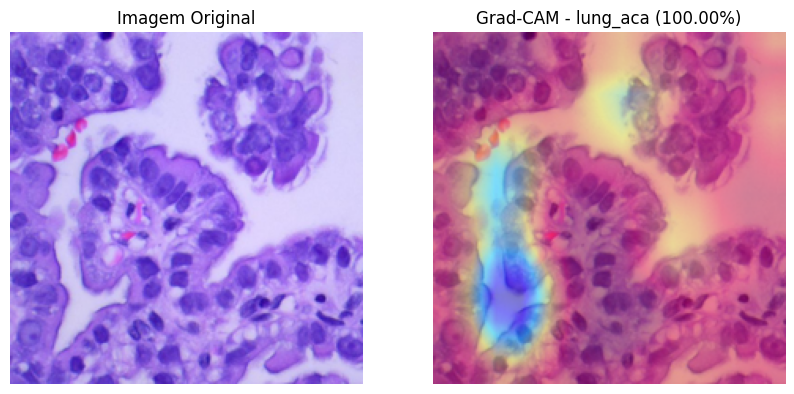

In [12]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Definir as transformações da ResNet
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Função Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook para capturar os gradientes
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output  # Captura as ativações

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Captura os gradientes

    def get_cam(self, image_tensor, class_idx=None):
        self.model.eval()
        image_tensor = image_tensor.unsqueeze(0).to(next(self.model.parameters()).device)  # Garante que está na mesma device do modelo
        
        output = self.model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = probabilities.max(dim=1)
        
        if class_idx is None:
            class_idx = predicted_class.item()
        
        self.model.zero_grad()
        one_hot = torch.zeros_like(output).to(output.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)
        
        activations = self.activations.detach()
        gradients = self.gradients.detach()

        weights = gradients.mean(dim=[2, 3], keepdim=True)  # Média espacial dos gradientes
        cam = (weights * activations).sum(dim=1).squeeze(0)
        
        cam = torch.clamp(cam, min=0).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam, predicted_class.item(), confidence.item()

# Função para exibir a imagem com Grad-CAM
def show_gradcam(image_path, model, target_layer, class_labels):
    image = Image.open(image_path).convert("RGB")
    image_tensor = data_transforms(image)
    
    gradcam = GradCAM(model, target_layer)
    cam, predicted_class, confidence = gradcam.get_cam(image_tensor)
    
    cam = cv2.resize(cam, (224, 224))
    cam = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    
    img_np = np.array(image.resize((224, 224)))
    
    superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Imagem Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - {class_labels[predicted_class]} ({confidence * 100:.2f}%)")
    plt.axis("off")
    
    plt.show()

# Carregar o melhor modelo treinado
best_model_path = checkpoint_callback.best_model_path
model = CancerClassifier.load_from_checkpoint(best_model_path)
model.eval()

# Enviar modelo para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Corrigir ReLU(inplace=True) para ReLU(inplace=False)
for idx, module in enumerate(model.model.features):
    if isinstance(module, torch.nn.ReLU):
        model.model.features[idx] = torch.nn.ReLU(inplace=False)


# Usar a última camada convolucional da VGG19
target_layer = model.model.features[35]


# Definir os rótulos das classes
class_names = ['lung_aca', 'lung_n', 'lung_scc']

# Testar com uma imagem
image_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca10.jpeg"
show_gradcam(image_path, model, target_layer, class_names)

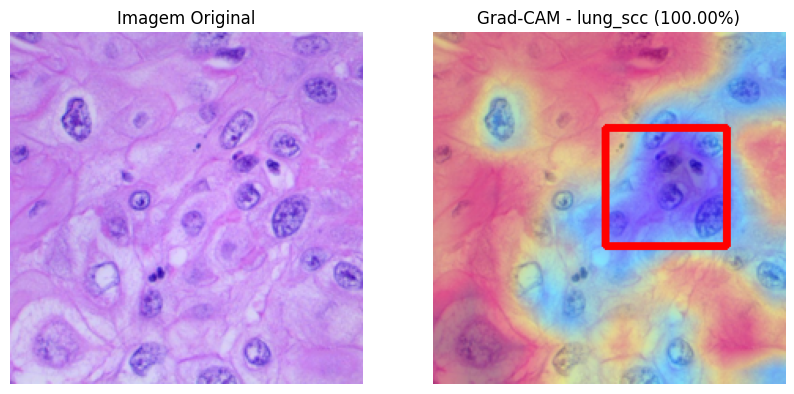

In [13]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Transformações da imagem
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hooks para capturar ativações e gradientes
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_full_backward_hook(self.backward_hook)  # <- aqui


    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def get_cam(self, image_tensor, class_idx=None):
        self.model.eval()
        image_tensor = image_tensor.unsqueeze(0).to(next(self.model.parameters()).device)

        output = self.model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = probabilities.max(dim=1)

        if class_idx is None:
            class_idx = predicted_class.item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output).to(output.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)

        activations = self.activations.detach()
        gradients = self.gradients.detach()

        weights = gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * activations).sum(dim=1).squeeze(0)

        cam = torch.clamp(cam, min=0).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam, predicted_class.item(), confidence.item()

# Visualizar Grad-CAM
def show_gradcam(image_path, model, target_layer, class_labels):
    image = Image.open(image_path).convert("RGB")
    image_tensor = data_transforms(image)

    gradcam = GradCAM(model, target_layer)
    cam, predicted_class, confidence = gradcam.get_cam(image_tensor)

    cam_resized = cv2.resize(cam, (224, 224))
    cam_uint8 = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)

    img_np = np.array(image.resize((224, 224)))
    superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Encontrar a região de maior ativação
    _, thresh = cv2.threshold(cam_uint8, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (255, 0, 0), 3)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Imagem Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - {class_labels[predicted_class]} ({confidence * 100:.2f}%)")
    plt.axis("off")
    plt.show()

# Carregar modelo treinado
best_model_path = checkpoint_callback.best_model_path
model = CancerClassifier.load_from_checkpoint(best_model_path)
model.eval()

# Corrigir ReLU(inplace=True) da VGG
for idx, module in enumerate(model.model.features):
    if isinstance(module, torch.nn.ReLU):
        model.model.features[idx] = torch.nn.ReLU(inplace=False)

# Enviar para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Última camada convolucional da VGG16
target_layer = model.model.features[28]

# Labels
class_labels = ['lung_aca', 'lung_n', 'lung_scc']

# Caminho da imagem de teste
image_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg"
show_gradcam(image_path, model, target_layer, class_labels)

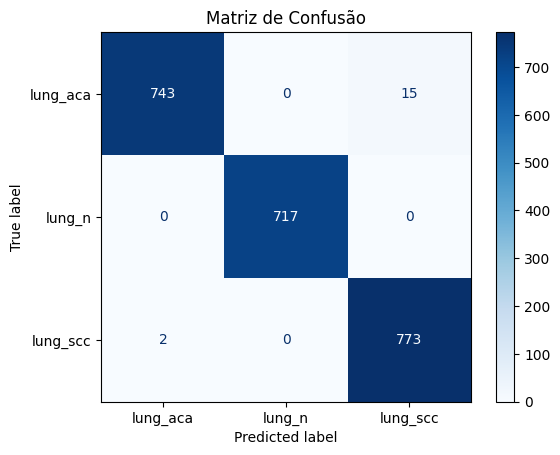


Métricas de Desempenho:
Acurácia: 0.9924
Sensibilidade (Recall - média macro): 0.9925
Precisão (Precision - média macro): 0.9928
F1-score (média macro): 0.9926

Relatório de Classificação:
              precision    recall  f1-score   support

    lung_aca       1.00      0.98      0.99       758
      lung_n       1.00      1.00      1.00       717
    lung_scc       0.98      1.00      0.99       775

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



In [14]:
plot_confusion_matrix_and_metrics(model, test_loader, class_names)